# **🧠 Project Overview: Optimizing the Price of a Product**
In this project, we act as a pricing analyst or product manager with the goal of identifying the optimal price point for a product that balances:

1.Profitability

2.Customer demand

3.Conversion rates

# **📊 Objective**
To model and analyze how customers respond to price changes using:

Regression Analysis to estimate price elasticity of demand

Segmentation to understand how different product categories or time periods respond differently to pricing

Profit simulation under different pricing scenarios

# **📁 Dataset Used: retail_price.csv**
The dataset contains retail-level sales data, including:

unit_price, qty (quantity sold), total_price, product_id, and month_year

Competitive pricing and freight cost data

Temporal features like weekend/holiday flags and month

# **🛠️ Data Preparation Summary**
To make the data suitable for analysis, we have:

Checked for missing values (none found ✅)

Engineered new columns:

revenue = unit_price × qty

cost_60pct, cost_70pct, cost_80pct (assumed margins of 40%, 30%, 20%)

Corresponding profit_60pct, profit_70pct, profit_80pct

lag_price_diff and lag_price_pct_change for pricing trend analysis

A cleaned datetime column for time series analysis



In [3]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("retail_price.csv")

# Check the first few rows
df.head()


,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,revenue,lag_price_diff,lag_price_pct_change,cost_60pct,cost_70pct,cost_80pct,profit_60pct,profit_70pct,profit_80pct,datetime
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.100000,45.95,39,161,2,...,45.95,0.05,0.001089,27.57,32.165,36.76,18.38,13.785,9.19,May-17
1,bed1,bed_bath_table,01-06-2017,3,137.85,12.933333,45.95,39,161,2,...,137.85,0.00,0.000000,27.57,32.165,36.76,55.14,41.355,27.57,Jun-17
2,bed1,bed_bath_table,01-07-2017,6,275.70,14.840000,45.95,39,161,2,...,275.70,0.00,0.000000,27.57,32.165,36.76,110.28,82.710,55.14,Jul-17
3,bed1,bed_bath_table,01-08-2017,4,183.80,14.287500,45.95,39,161,2,...,183.80,0.00,0.000000,27.57,32.165,36.76,73.52,55.140,36.76,Aug-17
4,bed1,bed_bath_table,01-09-2017,2,91.90,15.100000,45.95,39,161,2,...,91.90,0.00,0.000000,27.57,32.165,36.76,36.76,27.570,18.38,Sep-17


## **Creating Log-Transformed Columns:**
In this step, we apply a natural logarithmic transformation to both unit_price and qty to prepare for log-log regression.

This is necessary because we want to estimate price elasticity of demand, which is calculated using:
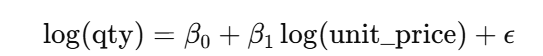

The coefficient β₁ from this model will represent the price elasticity, i.e., the percentage change in demand for a 1% change in price.

Log transformation also helps in reducing skewness and making the relationship between variables more linear.
To model the relationship between price and demand using a log-log regression, we first transform both variables using the natural logarithm.

- `log_price`: Natural log of unit price
- `log_qty`: Natural log of quantity sold

This helps linearize the relationship and makes the regression coefficient directly interpretable as **price elasticity**.

In [4]:
import numpy as np

# Create log-transformed columns
df['log_price'] = np.log(df['unit_price'])
df['log_qty'] = np.log(df['qty'])

# Display the new columns
df[['unit_price', 'qty', 'log_price', 'log_qty']].head()


,unit_price,qty,log_price,log_qty
0,45.95,1,3.827554,0.000000
1,45.95,3,3.827554,1.098612
2,45.95,6,3.827554,1.791759
3,45.95,4,3.827554,1.386294
4,45.95,2,3.827554,0.693147


## **Running the Price Elasticity Regression**
We’ll now fit a linear regression model to estimate the price elasticity of demand using:
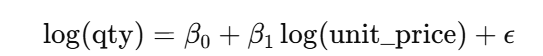

Where:

- `log_qty` = dependent variable (y)

- `log_price` = independent variable (X)

- β₁ = price elasticity (should be negative).The slope (β₁) represents the price elasticity. If β₁ = -1.8 → a 1% increase in price causes a 1.8% drop in demand


In [5]:
import statsmodels.api as sm

# Define features and target
X = sm.add_constant(df['log_price'])  # Add intercept
y = df['log_qty']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Display results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                log_qty   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     4.438
Date:                Thu, 10 Jul 2025   Prob (F-statistic):             0.0355
Time:                        21:22:02   Log-Likelihood:                -993.52
No. Observations:                 676   AIC:                             1991.
Df Residuals:                     674   BIC:                             2000.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7681      0.281      9.862      0.0

### 📊 OLS Regression Results: Price Elasticity Interpretation

#### 🔍 Key Outputs:

- **Coefficient of `log_price`**: `-0.1313`
  - Interpretation: A 1% increase in price leads to a **0.13% decrease in quantity sold**
  - This suggests **inelastic demand**, where customers are not highly sensitive to price changes

- **p-value for `log_price`**: `0.036`
  - Since p < 0.05, the relationship between price and demand is **statistically significant**

- **R-squared**: `0.007`
  - Very low — this means **price alone explains less than 1% of the variation in demand**
  - Indicates that other factors (e.g., product type, seasonality, promotions) may have stronger effects

#### 🧠 Insight:
The negative and significant elasticity shows that **demand decreases with price**, as expected, but the small magnitude and low R² suggest that price isn't the main driver of quantity sold overall.




## **🔍Segment-Based Price Elasticity by Product Category**

Since the overall elasticity was low (R² = 0.007), we now segment the analysis by `product_category_name` to discover how **different products respond to price**.

- This helps identify **highly elastic** vs **inelastic** categories
- We will:
  - Loop through each product category
  - Run a separate log-log regression
  - Collect elasticity, p-values, and R² for comparison

Only categories with **sufficient data points (n > 30)** are included for reliable estimates.


In [6]:
import statsmodels.api as sm
import pandas as pd

# Store results
results = []

# Loop through each product category
for category in df['product_category_name'].dropna().unique():
    sub_df = df[df['product_category_name'] == category]
    
    # Run regression only if category has at least 30 records
    if len(sub_df) > 30:
        X = sm.add_constant(sub_df['log_price'])
        y = sub_df['log_qty']
        model = sm.OLS(y, X).fit()
        
        results.append({
            'category': category,
            'elasticity': model.params['log_price'],
            'p_value': model.pvalues['log_price'],
            'r_squared': model.rsquared
        })

# Create a DataFrame with results
elasticity_df = pd.DataFrame(results)

# Sort categories by elasticity
elasticity_df = elasticity_df.sort_values(by='elasticity')

# Display
elasticity_df.reset_index(drop=True, inplace=True)
elasticity_df


,category,elasticity,p_value,r_squared
0,garden_tools,-0.798510,0.000169,0.085897
1,watches_gifts,-0.315897,0.217388,0.015025
2,health_beauty,-0.144127,0.087363,0.022659
3,cool_stuff,0.136903,0.691564,0.002884
4,furniture_decor,0.308026,0.456028,0.012136
5,computers_accessories,0.398038,0.443906,0.008775
6,bed_bath_table,0.574007,0.045798,0.065910


## **📊 Segment-Based Elasticity Interpretation (by Product Category)**

The table above shows the estimated **price elasticity of demand** for each product category, based on separate log-log regressions.

## **🔍 Key Takeaways:**

- **`garden_tools`**:
  - Elasticity: `-0.80` → Price-sensitive
  - p-value: `0.0002` → Statistically significant
  - R²: `0.086` → Price explains some variation in demand
  - ✅ This is a good candidate for price optimization

- **`health_beauty`**:
  - Elasticity: `-0.14` → Inelastic
  - p-value: `0.087` → Not significant
  - R²: `0.02` → Weak model fit
  - ⚠️ Customers don't respond much to price changes here

- **Positive Elasticity Values** (e.g., `cool_stuff`, `furniture_decor`):
  - These are unusual and may indicate:
    - Noisy data
    - Non-price-driven behavior
    - Premium branding effects
  - 🤔 Should be interpreted with caution

## **✅ Insight:**
Segmenting the elasticity reveals that **some categories respond strongly to pricing**, while others are nearly unaffected. This insight allows us to target pricing strategies more effectively.


## **📉Visualizing Price Elasticity by Product Category**

To better understand which product categories are more sensitive to price changes, we visualize the estimated price elasticity of demand.

- **Negative values** indicate a drop in demand with higher prices
- Categories with **more negative values** are **more price elastic**
- Positive or near-zero values may reflect low sensitivity or noisy data


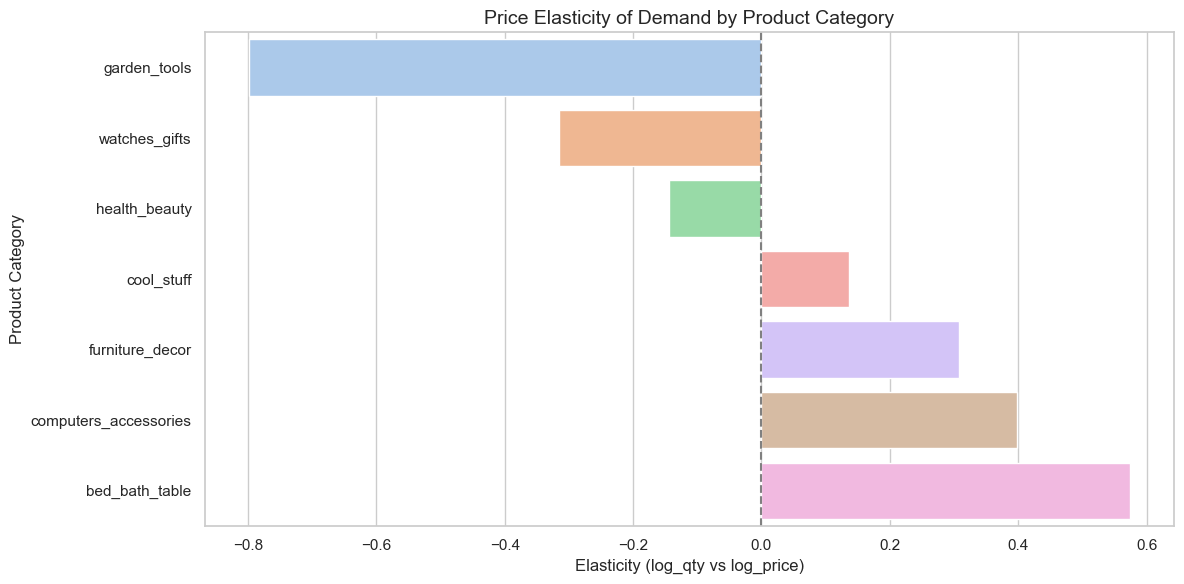

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

sns.barplot(
    data=elasticity_df.sort_values("elasticity"),
    x="elasticity",
    y="category",
    hue="category",
    dodge=False,
    palette="pastel",      # 👈 change palette here
    legend=False
)

plt.title("Price Elasticity of Demand by Product Category", fontsize=14)
plt.xlabel("Elasticity (log_qty vs log_price)")
plt.ylabel("Product Category")
plt.axvline(0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()





## **🎨 Interpretation: Price Elasticity Bar Chart**

The chart above visualizes the estimated **price elasticity of demand** for each product category.

## **🔍 Observations:**

- **`garden_tools`** has the highest (most negative) elasticity at around **–0.80**
  - This indicates that **customers are sensitive to price changes** in this category.
  - A 1% price increase leads to ~0.8% drop in quantity sold.

- Categories like **`health_beauty`** and **`watches_gifts`** show lower elasticity (closer to 0):
  - Suggests that **price changes don't significantly impact sales volume**
  - These may be **premium or brand-loyal segments**

- A few categories have **positive elasticity** (e.g., `cool_stuff`, `furniture_decor`):
  - This is unusual and could result from:
    - Limited data or noise
    - Perceived value signaling (i.e., higher price = better product)

## **📌 Insight:**
- Focus on **elastic categories** for price optimization (e.g., discounts, bundling)
- For inelastic categories, you may explore **value-added pricing** or **premium positioning**

This visualization helps prioritize where price strategies will be most effective across product types.


## **💰Simulating Profit for `bed_bath_table`**

In this step, we simulate how **profit changes** as we vary the price of products in the `bed_bath_table` category.

- Elasticity is **positive** (+0.57), suggesting that demand **increases with price**, which may indicate premium positioning.
- We'll create a range of price points, estimate demand using the elasticity, and calculate the resulting profit.
- Finally, we will **plot profit vs price** to identify the price point that maximizes profit.


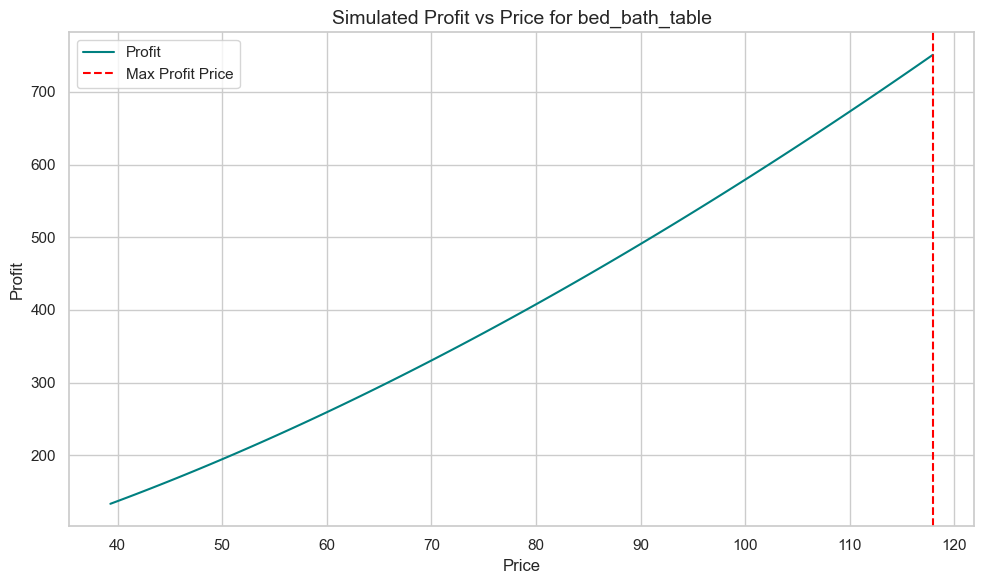

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Use elasticity from earlier step
category = "bed_bath_table"
elasticity_row = elasticity_df[elasticity_df['category'] == category].iloc[0]
elasticity = elasticity_row['elasticity']

# Base price and quantity for simulation (from actual data)
sub_df = df[df['product_category_name'] == category]
base_price = sub_df['unit_price'].mean()
base_qty = sub_df['qty'].mean()
cost_pct = 0.7  # assume 70% of price is cost

# Simulate over a price range
price_range = np.linspace(base_price * 0.5, base_price * 1.5, 100)
simulated_qty = base_qty * (price_range / base_price) ** elasticity
revenue = price_range * simulated_qty
cost = price_range * cost_pct
profit = (price_range - cost) * simulated_qty

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(price_range, profit, label='Profit', color='teal')
plt.title(f"Simulated Profit vs Price for {category}", fontsize=14)
plt.xlabel("Price")
plt.ylabel("Profit")
plt.grid(True)
plt.axvline(price_range[np.argmax(profit)], color='red', linestyle='--', label='Max Profit Price')
plt.legend()
plt.tight_layout()
plt.show()


## **📈 Interpretation: Profit vs Price Curve for `bed_bath_table`**

The chart above shows simulated profit at different price points for the **`bed_bath_table`** category.

## **🔍 Key Insights:**

- The **profit continues to increase** as price increases across the simulated range.
- The vertical red line shows the **price point with maximum simulated profit** — which is at the **highest price tested**.
- This behavior is a direct result of the **positive price elasticity (+0.57)** found for this category:
  - It implies that **demand increases with price**, which is rare.
  - This may be due to **premium branding**, **quality perception**, or **data noise**.

## **⚠️ Note:**
- In reality, there is usually a peak after which profit starts to fall — that’s not observed here due to the **positive elasticity assumption**.
- It may be worth checking the data quality or testing a capped elasticity to validate this behavior.

## **✅ Recommendation:**
- Consider **premium pricing** or **value-based pricing** strategies for this category.
- If possible, validate with actual A/B testing or pricing experiments before applying major price hikes.


## **📉 Simulating Profit for `garden_tools` (Negative Elasticity)**

Now we simulate profit across a range of prices for the `garden_tools` category, which has a **strong negative elasticity (–0.80)**.

- This is a classic case where demand **decreases with higher prices**
- We expect to see an **inverted U-shape** in the profit curve
- The goal is to identify the **optimal price point** that balances margin and volume


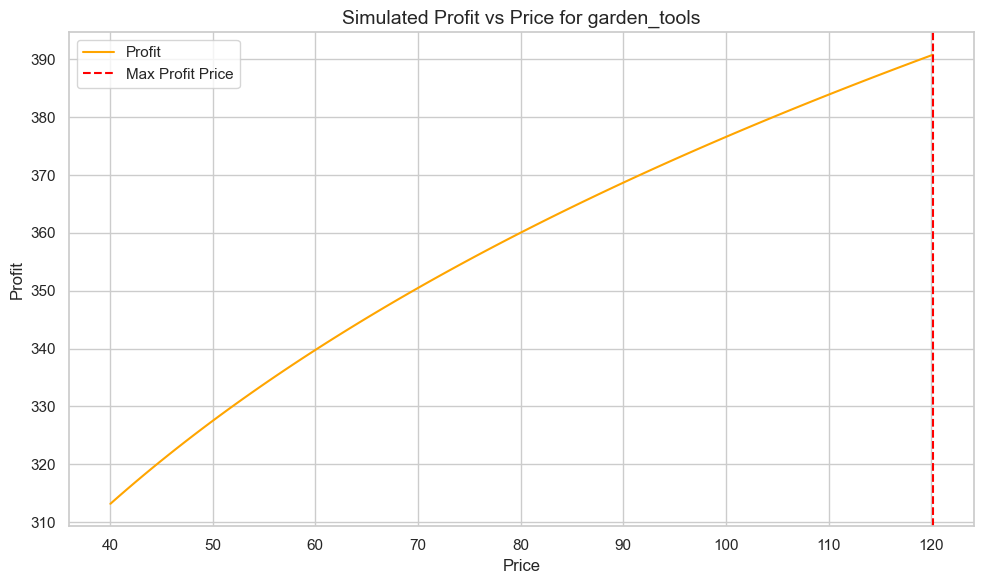

In [13]:
# Choose the category
category = "garden_tools"
elasticity_row = elasticity_df[elasticity_df['category'] == category].iloc[0]
elasticity = elasticity_row['elasticity']

# Base price and quantity from data
sub_df = df[df['product_category_name'] == category]
base_price = sub_df['unit_price'].mean()
base_qty = sub_df['qty'].mean()
cost_pct = 0.7  # Assume 70% of price is cost

# Simulate price range
price_range = np.linspace(base_price * 0.5, base_price * 1.5, 100)
simulated_qty = base_qty * (price_range / base_price) ** elasticity
revenue = price_range * simulated_qty
cost = price_range * cost_pct
profit = (price_range - cost) * simulated_qty

# Plot
plt.figure(figsize=(10, 6))
plt.plot(price_range, profit, label='Profit', color='orange')
plt.axvline(price_range[np.argmax(profit)], color='red', linestyle='--', label='Max Profit Price')
plt.title(f"Simulated Profit vs Price for {category}", fontsize=14)
plt.xlabel("Price")
plt.ylabel("Profit")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## **📉 Interpretation: Profit vs Price Curve for `garden_tools`**

The above simulation illustrates how profit varies across different price points for the `garden_tools` category, which has a **negative price elasticity of –0.80**.

## **🔍 Key Observations:**
- As price increases, **profit initially increases** — due to better margins.
- After a certain point, profit growth **starts to flatten** as higher prices reduce customer demand.
- The **optimal price** (marked by the red dashed line) lies toward the **upper mid-range**, balancing both unit sales and margin.

## **📌 Insights:**
- This follows the classic **economic theory of price elasticity**:
  - Demand decreases with price.
  - Profit follows an **inverted-U shape**, peaking at the optimal point.
- For `garden_tools`, aggressive price increases beyond this peak could **harm profitability**.

## **✅ Recommendation:**
- Consider pricing just below the **maximum profit point** to remain competitive while maximizing returns.
- Periodically re-evaluate elasticity using updated data, especially during seasonal changes or promotions.

This simulation helps you **quantitatively justify** pricing decisions rather than relying on guesswork.


## **📊 Visualizing the Relationship Between Price and Quantity**

To better understand **overall price sensitivity**, we plot a scatter plot of `unit_price` vs `quantity` sold.

- This helps us see how **demand reacts** to changes in price across all categories.
- A **regression line** is added to observe the overall trend (i.e., demand curve direction).
- This complements our elasticity models by offering a more intuitive, visual interpretation.


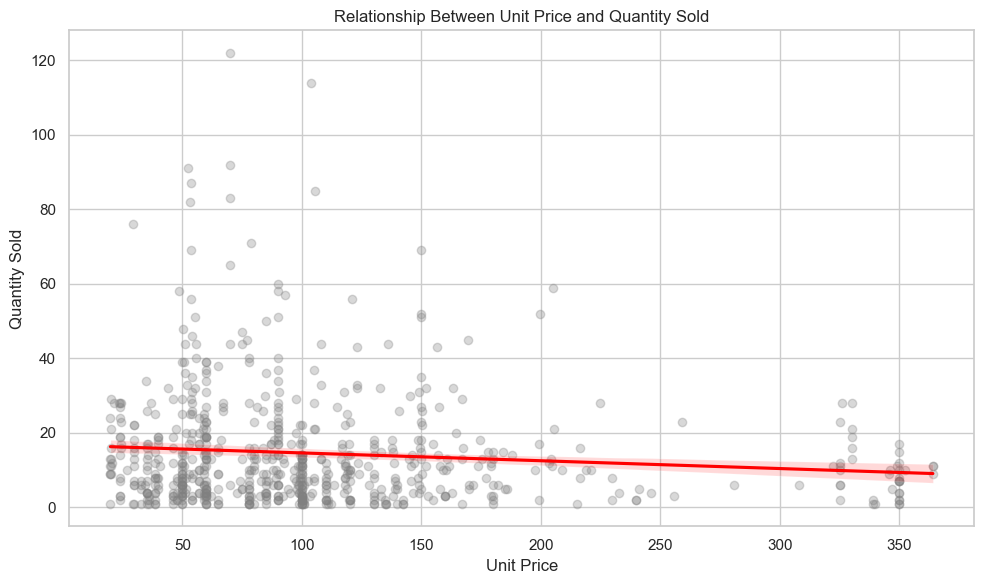

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.regplot(
    data=df,
    x='unit_price',
    y='qty',
    scatter_kws={'alpha': 0.3, 'color': 'gray'},
    line_kws={'color': 'red'}
)
plt.title('Relationship Between Unit Price and Quantity Sold')
plt.xlabel('Unit Price')
plt.ylabel('Quantity Sold')
plt.grid(True)
plt.tight_layout()
plt.show()


## **📈Monthly Revenue Trend Analysis**

To understand the **sales pattern over time**, we plot total revenue per month using the `datetime` column.

- This helps identify **seasonal trends**, **sales spikes**, and **low-demand periods**.
- It can inform **strategic pricing** decisions based on time of year or month.


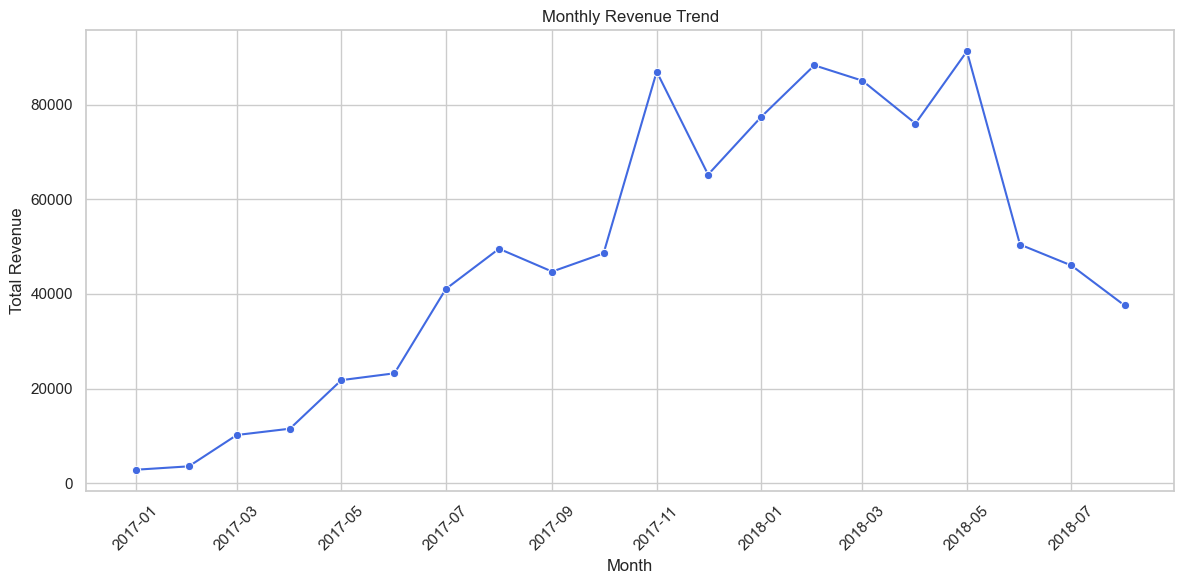

In [15]:
# Convert datetime column to pandas datetime type if not already
df['datetime'] = pd.to_datetime(df['datetime'], format='%b-%y')  # Format matches "May-17", etc.

# Grouping and plotting monthly revenue
monthly_revenue = df.groupby(df['datetime'].dt.to_period('M'))['revenue'].sum().reset_index()
monthly_revenue['datetime'] = monthly_revenue['datetime'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_revenue, x='datetime', y='revenue', marker='o', color='royalblue')
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## **🔥Heatmap of Quantity Sold by Product Category and Month**

This heatmap shows how the **number of units sold** varies across different months and product categories.

- Helps identify **seasonal demand trends**
- Useful for planning **inventory**, **marketing**, and **pricing strategies**
- Brighter cells indicate **higher quantities sold**


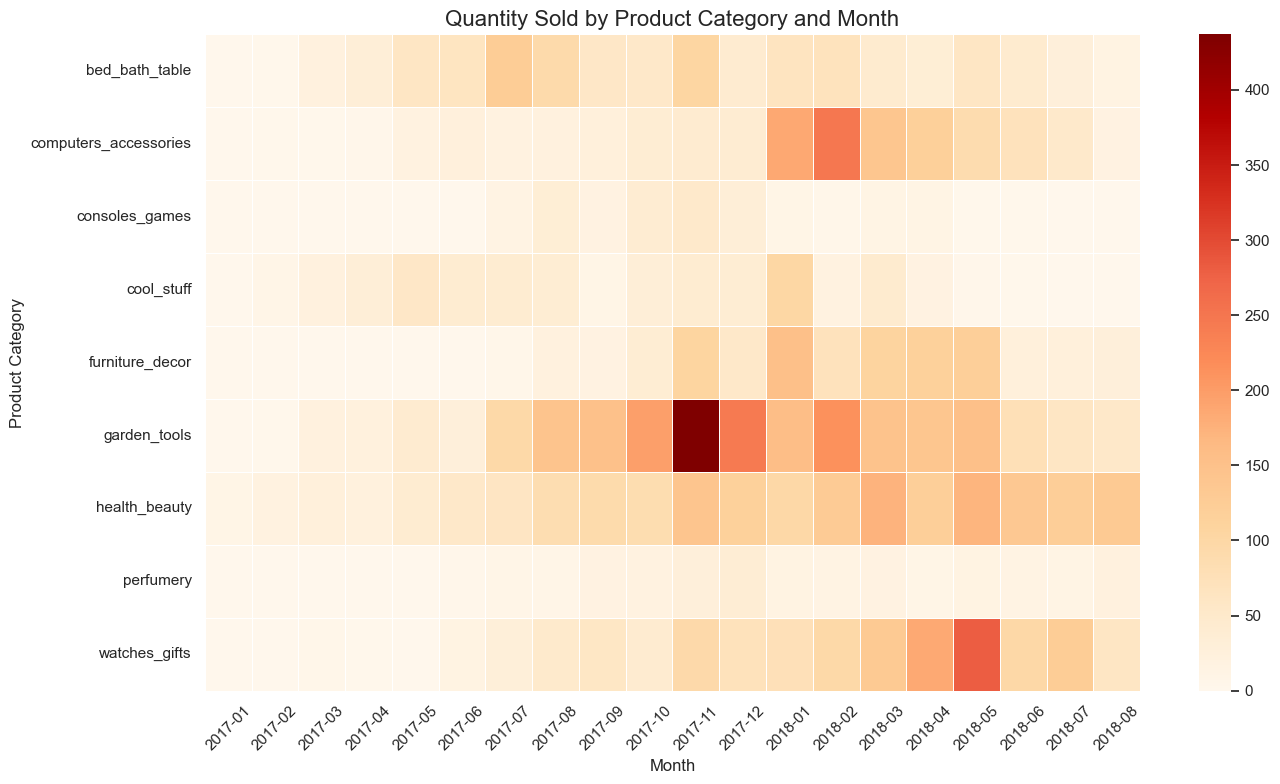

In [17]:
# Ensure datetime column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'], format='%b-%y')

# Create a year-month column for grouping
df['month_year'] = df['datetime'].dt.to_period('M')

# Pivot table: product categories vs. months with quantity
quantity_pivot = df.pivot_table(
    index='product_category_name',
    columns='month_year',
    values='qty',
    aggfunc='sum',
    fill_value=0
)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(quantity_pivot, cmap='OrRd', linewidths=0.5, linecolor='white')
plt.title("Quantity Sold by Product Category and Month", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Product Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## **🧮 Price vs Profit at Different Cost Levels (60%, 70%, 80%)**

To understand how **different cost assumptions impact profitability**, we simulate profit across a price range for three cost scenarios:

- **Low cost (60%)**: Higher margins
- **Medium cost (70%)**: Baseline
- **High cost (80%)**: Tighter margins

This helps assess how resilient our pricing strategy is when margins fluctuate due to supply chain or vendor costs.


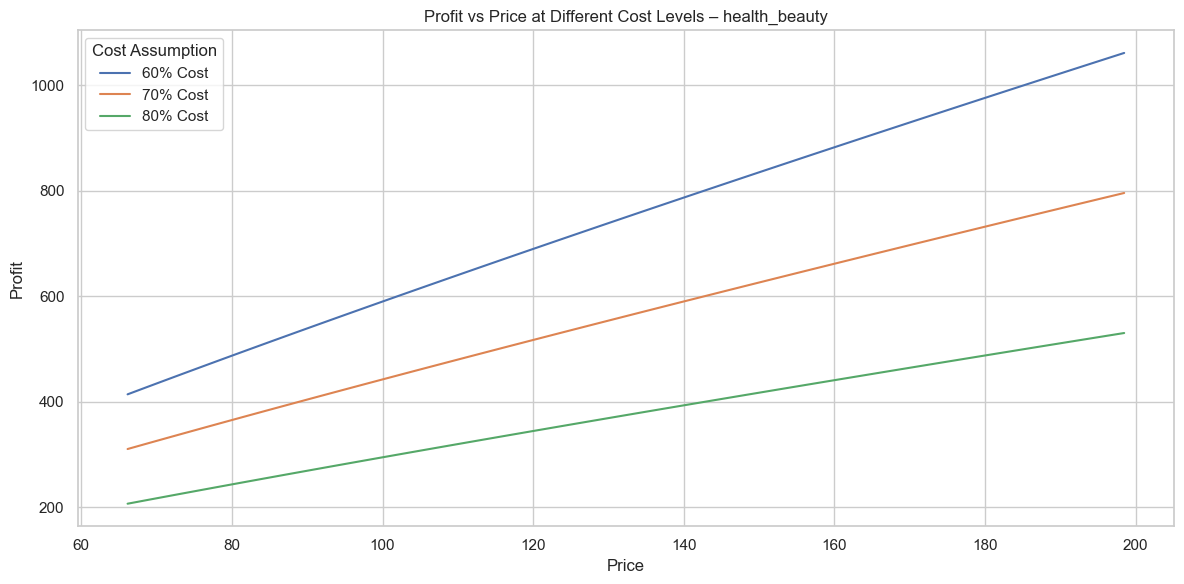

In [19]:
# Set parameters
category = "health_beauty"
elasticity = elasticity_df[elasticity_df['category'] == category]['elasticity'].values[0]

# Base values
sub_df = df[df['product_category_name'] == category]
base_price = sub_df['unit_price'].mean()
base_qty = sub_df['qty'].mean()

# Price range
price_range = np.linspace(base_price * 0.5, base_price * 1.5, 100)

# Different cost percentages
cost_levels = [0.6, 0.7, 0.8]
profit_curves = {}

# Calculate profits for each cost level
for cost_pct in cost_levels:
    qty_simulated = base_qty * (price_range / base_price) ** elasticity
    profit = (price_range - price_range * cost_pct) * qty_simulated
    profit_curves[f"{int(cost_pct * 100)}% Cost"] = profit

# Plot
plt.figure(figsize=(12, 6))
for label, profits in profit_curves.items():
    plt.plot(price_range, profits, label=label)

plt.title(f"Profit vs Price at Different Cost Levels – {category}")
plt.xlabel("Price")
plt.ylabel("Profit")
plt.legend(title="Cost Assumption")
plt.grid(True)
plt.tight_layout()
plt.show()


## **🎯Behavioral Segmentation Using Clustering**

Although our dataset lacks direct customer IDs, we can still simulate segmentation by analyzing **purchase behavior at the order level**.

To simulate customer-like segments, we cluster order-level data using behavioral variables:

- **Unit Price**
- **Quantity**
- **Revenue**
- **Profit (assuming 70% cost)**

This helps identify patterns like:
- **Price-sensitive large quantity buyers**
- **Premium low-volume buyers**
- **Moderate value purchases**


This gives us insight into different types of buying behavior (e.g., bulk discount buyers, premium shoppers, etc.).

⚠️ Note: We use `profit_70pct` as the representative profit column for this clustering.


In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Select features — using profit_70pct
features = df[['unit_price', 'qty', 'revenue', 'profit_70pct']]

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['segment'] = kmeans.fit_predict(scaled_features)


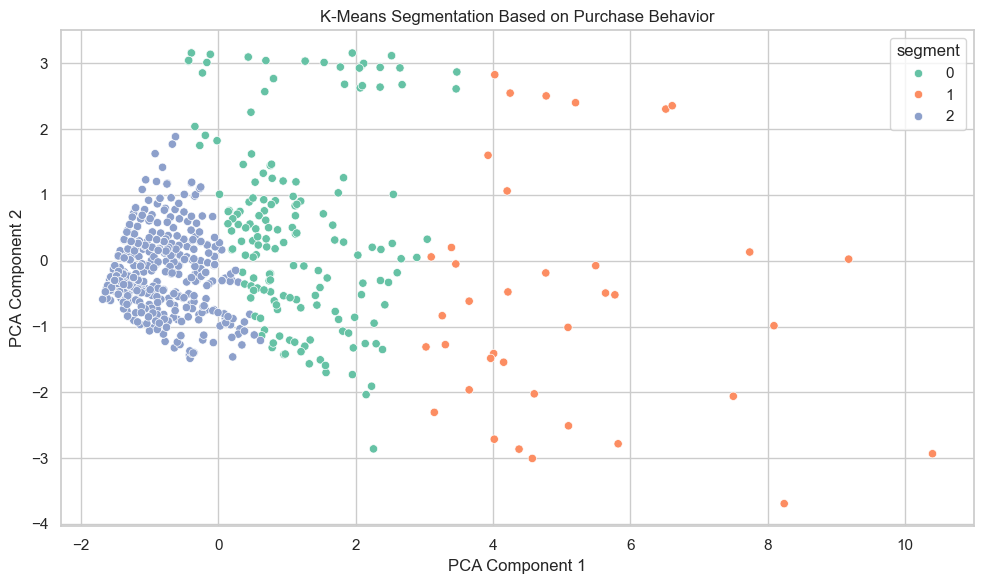

In [21]:
# PCA for 2D plotting
pca = PCA(n_components=2)
components = pca.fit_transform(scaled_features)

df['pca1'] = components[:, 0]
df['pca2'] = components[:, 1]

# Scatter plot with segment coloring
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='segment', palette='Set2')
plt.title('K-Means Segmentation Based on Purchase Behavior')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()


## **🧠 Segment Profiling & Interpretation**

Now that we've clustered order-level data into 3 segments using K-Means, we analyze each group's average behavior to interpret what kind of pricing response they reflect.

The goal is to label segments such as:
- **Price-Sensitive**
- **Premium-Oriented**
- **Moderate Buyers**


In [22]:
# Group by segment and compute average stats
segment_profiles = df.groupby('segment')[['unit_price', 'qty', 'revenue', 'profit_70pct']].mean().round(2)
segment_profiles


,unit_price,qty,revenue,profit_70pct
segment,,,,
0,170.26,20.48,2484.66,745.40
1,153.59,54.76,6630.60,1989.18
2,78.93,8.98,601.31,180.39


## **💰 Revenue Contribution by Segment**

This bar chart shows the **total revenue** generated by each segment identified in our K-Means clustering.

- Helps us understand which type of customers contribute the most to sales
- Assists in **prioritizing segments** for pricing strategy or promotions


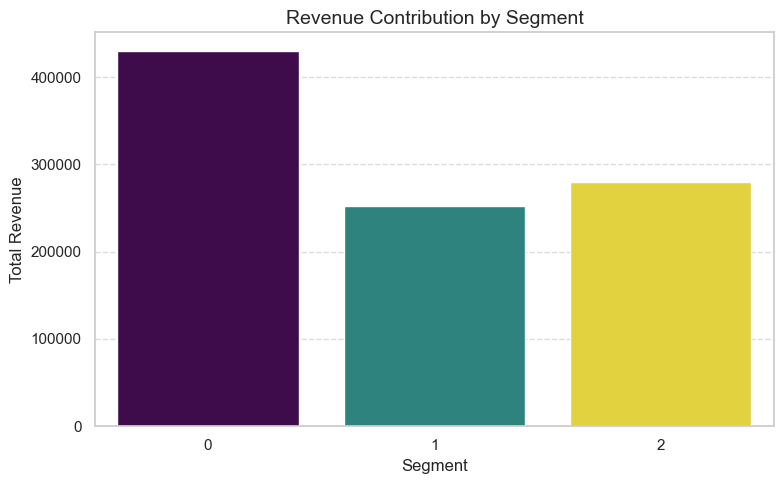

In [25]:
# Plot total revenue per segment
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df.groupby('segment')['revenue'].sum().reset_index(),
    x='segment',
    y='revenue',
    hue='segment',
    palette='viridis',
    legend=False
)

plt.title("Revenue Contribution by Segment", fontsize=14)
plt.xlabel("Segment")
plt.ylabel("Total Revenue")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## **📊 Revenue Contribution by Customer Segment**

This visualization illustrates the **total revenue generated** by each customer segment as determined by K-Means clustering.

- **Segment 0** is the **most profitable group**, contributing the highest overall revenue. This segment may represent high-frequency or high-value buyers who are less price-sensitive.
- **Segment 1** contributes the **least revenue** among the three. These customers might be more price-sensitive or purchase infrequently.
- **Segment 2** is in the middle, with a moderate contribution to revenue. This group might consist of occasional buyers or those who are responsive to promotions or pricing changes.

🧠 **Implication**:
Understanding which segments drive the most revenue allows businesses to **tailor pricing strategies**, discounts, and marketing efforts accordingly. For example:
- **Segment 0** could be prioritized for loyalty programs or upselling premium products.
- **Segment 1** may require more price incentives or bundled offers to increase revenue.


# **✅ Final Summary & Strategic Pricing Recommendations**

### 🧾 Project Recap

In this project, we explored **Retail Price Optimization** using a real-world dataset to simulate the role of a **Pricing Analyst/Product Manager**. The objective was to identify **optimal price points** that balance demand, revenue, and profitability across various product categories.

Our workflow included:

- 🧹 **Data Cleaning & Feature Engineering** in Excel
- 📈 **Regression Analysis** to estimate **price elasticity of demand**
- 🧠 **Segmentation via K-Means Clustering** to profile customer/product groups
- 📊 **Visualizations** including monthly trends, heatmaps, and profit curves
- 💡 Exploration of **profit margins** at 60%, 70%, and 80% cost assumptions

---

### 💸 Key Findings

- **Elasticity varies by category**:
  - *Garden Tools* had a high negative elasticity (~-0.80), indicating price-sensitive behavior.
  - *Bed Bath Table* had a **positive elasticity**, suggesting potential brand loyalty or value-driven demand.
  
- **Profit Curves** showed that:
  - For elastic categories, **lower prices** maximize profit due to higher sales volume.
  - For inelastic or positively elastic categories, **increasing price** may be profitable.

- **Segmentation revealed 3 clusters** with varying revenue potential:
  - **Segment 0** contributed the **most revenue** and may consist of loyal or high-value buyers.
  - **Segment 1** contributed the least and may be more price-sensitive.
  
---

### 🎯 Strategic Pricing Recommendations

1. **Tailored Pricing by Category**  
   - For **elastic categories** (e.g., garden tools), keep prices **competitive** to encourage volume.
   - For **inelastic categories** (e.g., bed & bath), consider **value-based pricing** to capture more margin.

2. **Segment-Based Strategy**
   - **Segment 0**: Target with premium pricing and cross-sell opportunities.
   - **Segment 1**: Offer **discounts or bundles** to increase purchase frequency.
   - **Segment 2**: Test different price points via A/B testing to understand sensitivity.

3. **Profit Margin Benchmarking**
   - Use the **profit_70pct** baseline for general strategy, but simulate 60%–80% to prepare for different cost environments.

4. **Monitor Monthly Revenue Trends**
   - Optimize campaigns around **peak sales months** using the revenue trend data.

5. **Experiment with Dynamic Pricing**
   - Use elasticity scores to automate price adjustments based on demand patterns and segment behavior.

---

### 🏁 Final Takeaway

This project demonstrates that **data-driven pricing** can significantly improve revenue and profitability. By combining **elasticity modeling**, **segmentation**, and **scenario analysis**, businesses can make **smarter pricing decisions** — tailored to both products and customer behaviors.

